In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

In [32]:
df = pd.read_csv("Sales_data.csv") # Initialize DataFrame

df = df[["City", "Date", "gross income", "Product line", "Total", "cogs", "Quantity"]] # Remove unnecessary columns

df = df.rename(columns={"cogs" : "cost price"}) # Rename column for clarity

df.dropna(subset=["Date"], inplace=True) # Delete rows with missing dates

df.drop_duplicates(subset=None, keep="first", inplace=True) # Check for and remove duplicate rows if present

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y") # Ensure Date column is in DateTime format

df["Date"] =  df["Date"].sort_values(ascending=True).values # Sort dates in ascending order

def round_off(number):
    return round(number, 2)

df["gross income"] = df["gross income"].apply(round_off) # Round off gross income values to 2 decimals
df["Total"] = df["Total"].apply(round_off)

# Breakdown Amount of Sales per City
city_groups = df.groupby("City")
print(city_groups["gross income"]) # Print the amount of sales per city

# df.drop_duplicates(subset="Date", keep="first") # Remove duplicate dates

# Combine all stats for each date
df_grouped_gross_income = df.groupby('Date', as_index=False)['gross income'].sum()
df_grouped_total = df.groupby('Total', as_index=False)['Total'].sum()
df_grouped_cost_price = df.groupby('cost price', as_index=False)['cost price'].sum()
df_grouped_quantity = df.groupby('Quantity', as_index=False)['Quantity'].sum()

# Update DataFrame with unique dates
new_df = pd.DataFrame()
new_df["Date"] = df["Date"].unique()
new_df["Total"] = df_grouped_total["Total"]
new_df["cost price"] = df_grouped_cost_price["cost price"]
new_df["Quantity"] = df_grouped_quantity["Quantity"]
new_df["gross income"] = df_grouped_gross_income["gross income"]

# Create DataFrames grouped by city
yangon_df = df[df["City"] == "Yangon"]
naypyitaw_df = df[df["City"] == "Naypyitaw"]
mandalay_df = df[df["City"] == "Mandalay"]

In [33]:
df.head()

,City,Date,gross income,Product line,Total,cost price,Quantity
0,Yangon,2019-01-01,26.14,Health and beauty,548.97,522.83,7
1,Naypyitaw,2019-01-01,3.82,Electronic accessories,80.22,76.40,5
2,Yangon,2019-01-01,16.22,Home and lifestyle,340.53,324.31,7
3,Yangon,2019-01-01,23.29,Health and beauty,489.05,465.76,8
4,Yangon,2019-01-01,30.21,Sports and travel,634.38,604.17,7


In [11]:
new_df.head()

,Date,Total,cost price,Quantity,gross income
0,2019-01-01,10.68,10.17,112.0,206.86
1,2019-01-02,12.69,12.09,182.0,155.28
2,2019-01-03,13.17,12.54,270.0,91.45
3,2019-01-04,13.42,12.78,436.0,135.12
4,2019-01-05,14.68,13.98,510.0,190.86


In [12]:
# Plot Monthly Sales Trends

# January Seasonality Trend
jan_sales_trends_fig = px.line(new_df, x=new_df["Date"][:31], y=new_df["gross income"][:31], title="January Seasonality Trend")
jan_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
jan_sales_trends_fig.show()

# Febraury Seasonality Trend
feb = new_df[new_df["Date"].dt.month == 2]
feb_sales_trends_fig = px.line(new_df, x=feb["Date"], y=new_df["gross income"][:len(feb)], title="February Seasonality Trend")
feb_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
feb_sales_trends_fig.show()

# March Seasonality Trend
mar = new_df[new_df["Date"].dt.month == 3]
mar_sales_trends_fig = px.line(new_df, x=mar["Date"], y=df["gross income"][:len(mar)], title="March Seasonality Trend")
mar_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
mar_sales_trends_fig.show()

In [13]:
sales_per_country_figure = px.bar(df, x="City", y="gross income", title="Total Sales per city") # Bar plot for total sales per city

sales_per_country_figure.show()

In [14]:
product_sales = df.groupby("Product line").count() # Group sales by the products lines

top_5_product_sales = product_sales["gross income"].sort_values(ascending=False)[:5]

print(f"Top 5 highest selling products: \n\n{top_5_product_sales}")

Top 5 highest selling products: 

Product line
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Name: gross income, dtype: int64


In [15]:
df["Profit Margins"] = ((df["Total"] - df["cost price"]) / df["Total"]) * 100 # Create Profit Margins column
df["Profit Margins"] = df["Profit Margins"].apply(round_off)

print(df["Profit Margins"].unique()) # Display unique profit margins

[4.76 4.77 4.75 4.78 4.74 4.73]


## SARIMA Model

In [16]:
def adf_test(timeseries):
    # Tests if timeseries is statioary
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
# Difference data
new_df["gross income"] = new_df["gross income"].diff()

adf_test(new_df["gross income"].dropna())

ADF Statistic: -7.806300460520217
p-value: 7.266384381582024e-12


<Figure size 1200x600 with 0 Axes>

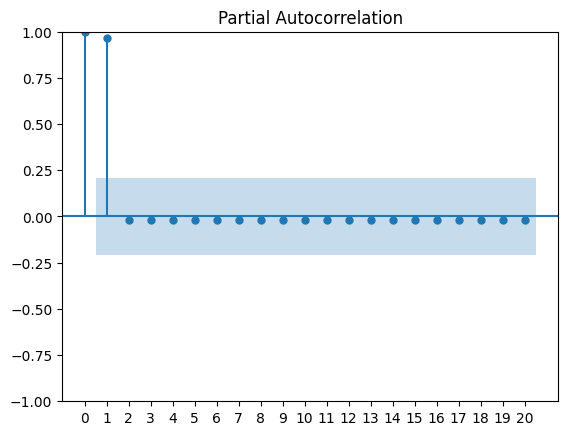

In [17]:
# Determine p variable with Partial Autocorrelation Plot
plt.figure(figsize=(12, 6))
plot_pacf(new_df["Date"])
plt.xticks(np.arange(0,21, 1))
plt.show() # p = 2

In [18]:
# Determine d variable by observing trend of data
overall_trend_fig = px.line(new_df, x="Date", y="gross income", title="Overall Trend of gross income")
overall_trend_fig.show() # d = 1

In [19]:
arima_model = ARIMA(new_df["gross income"], order=(2, 1, 1)) # Create ARIMA model
arima_model_fitted = arima_model.fit() # Fit the model

print(arima_model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           gross income   No. Observations:                   89
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -516.120
Date:                Mon, 14 Oct 2024   AIC                           1040.240
Time:                        09:23:48   BIC                           1050.150
Sample:                             0   HQIC                          1044.233
                                 - 89                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6475      0.119     -5.463      0.000      -0.880      -0.415
ar.L2         -0.2594      0.134     -1.941      0.052      -0.521       0.003
ma.L1         -0.9997     14.178     -0.071      0.9

In [20]:
arima_forecast = arima_model_fitted.get_forecast(steps=10) # ARIMA Forecast
arima_forecast_values = arima_model_fitted.forecast(steps=10).values

# Get confidence interval and forecast mean
forecast_mean = arima_forecast.predicted_mean
confidence_intervals = arima_forecast.conf_int()

# Get lower and upper confidence intervals
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

[]

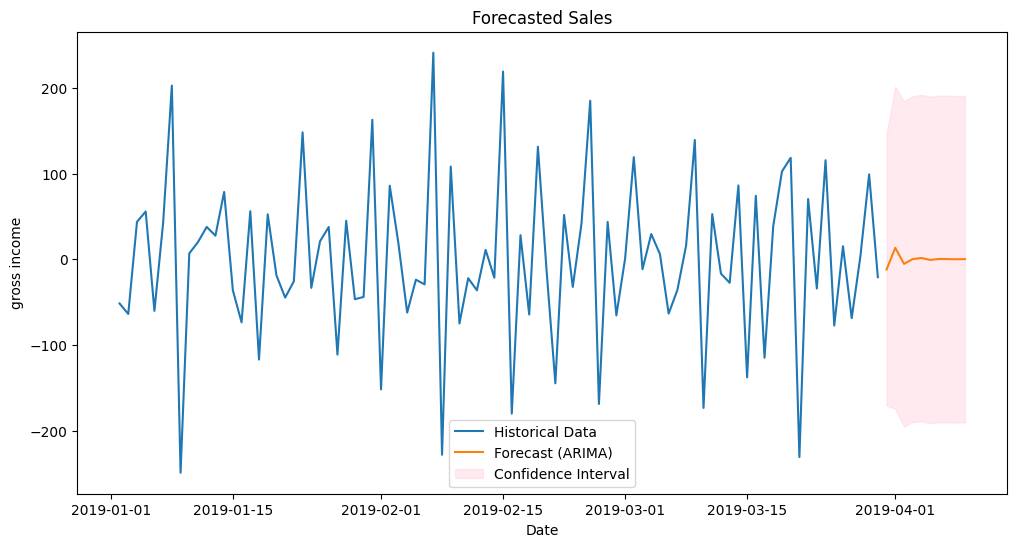

In [21]:
# Plot Forecast with Confidence Interval
forecast_index = pd.date_range(new_df["Date"].iloc[-1], periods=10 + 1, freq='D')[1:]
plt.figure(figsize=(12, 6))
sns.lineplot(x=new_df["Date"], y=new_df["gross income"], label="Historical Data")
sns.lineplot(x=forecast_index, y=arima_forecast_values, label="Forecast (ARIMA)")
plt.fill_between(forecast_index, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.title("Forecasted Sales")
plt.legend()
plt.plot()

In [22]:
# Create new ARIMA DataFrame
arima_df = pd.DataFrame(forecast_index)
arima_df.rename(columns={0 : "Date"}, inplace=True)
arima_df["ARIMA Forecast"] = arima_forecast_values # Add arima forecast values

# Add DataFrames to csv files
df.to_csv("processed_sales.csv", index=False)
arima_df.to_csv("ARIMA_data.csv", index=False)
new_df.to_csv("timeseries_data.csv", index=False)
yangon_df.to_csv("Yangon Sales", index=False)
naypyitaw_df.to_csv("Naypyitaw Sales", index=False)
mandalay_df.to_csv("Mandalay Sales", index=False)